In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

# Text generation with a miniature GPT

https://keras.io/examples/generative/text_generation_with_miniature_gpt/   
**References:**

- [GPT](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)
- [GPT-2](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)
- [GPT-3](https://arxiv.org/abs/2005.14165)

## Setup

In [2]:
#!pip install --upgrade keras
import keras
keras.__version__
# 3.3.3 24.05
# 3.4.1 24.10

'3.8.0'

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

## Prepare the data for word-level language modelling

Download the IMDB dataset and combine training and validation sets for a text
generation task.

In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  57.4M      0  0:00:01  0:00:01 --:--:-- 57.4M


### Create a list all files  
>한 문장이 하나의 file  
전체 file의 path를 저장  을 묶어서 사용  



In [5]:
batch_size = 128
filenames = []
directories = [ "aclImdb/train/pos",
                "aclImdb/train/neg",
                "aclImdb/test/pos",
                "aclImdb/test/neg", ]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))
print(f"{len(filenames)} files") # 50000 files

random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)# file path만 가지고 있음, 필요할때 문장을 하나씩 읽어옴
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

50000 files


In [6]:
#p(next(iter(text_ds)))      #(128,)
p(next(iter(text_ds))[:3])
# Tensor객체에 UTF-8로 encoding된 binary string(byte sequence)으로 저장

Shape:(3,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [b"In terms of quality movies, this isn't one of them. It's actually the first Chuck Norris movie I've seen and I was left pretty underwhelmed. The fight scenes are slow and don't have a lot of variety. Norris just uses a lot of roundhouse kicks on all the bad guys coming after him which makes the fights pretty boring. The movie also is quite short, but for some reason the movie doesn't even seem finished when it ends. It's a pretty anti-climatic ending. All the same though, I've watched a lot of bad movies, and this isn't one of the worst that I've seen. It's worth a watch, I'm guessing especially for Norris fans. There's also nothing like seeing a group of rigs hurtling down the desert which in my opinion was the highlight of the movie."
 b"To me Bollywood movies are not generally up to much, though they are still quite desired and Bollywood is a big file maker as they have their own fans.<br /><br />The o

In [7]:
## 10개 문장의 내용과 길이 확인
tot_len = 0
for i, value in enumerate(next(iter(text_ds))):
  str_len = len(value.numpy())
  if i<10:
    print(f"len({str_len}):{value}")
  tot_len += str_len
print(f"total({tot_len})")

len(1209):b'The only possible way to enjoy this flick is to bang your head against the wall, allow some internal hemorrhaging of the brain, let a bunch of your brain cells die and once you are officially mentally retarded, perhaps then you *MIGHT* enjoy this film.<br /><br />The only saving grace was the story between Raju and Stephanie. Govinda was excellent in the role of the cab driver and so was the Brit girl. Perhaps if they would have created the whole movie on their escapades in India and how they eventually fall in love would have made it a much more enjoyable film.<br /><br />The only reason I gave it a 3 rating is because of Govida and his ability as an actor when it comes to comedy.<br /><br />Juhi Chawla and Anil Kapoor were wasted needlessly. Plus the scene at Heathrow of the re-union was just too much to digest. Being an international traveler in the post 9/11 world, Anil Kapoor would have got himself shot much before he even reached the sky bridge to profess his true lov

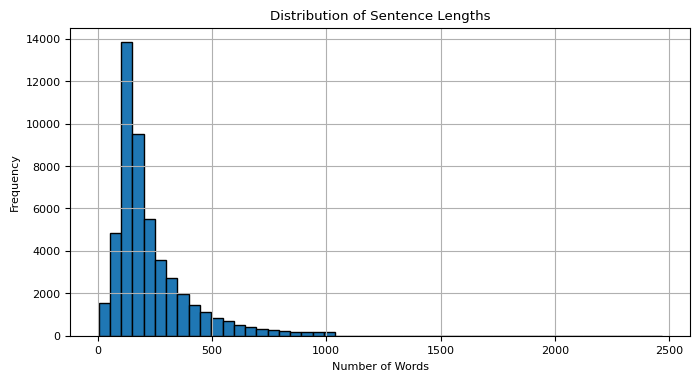

In [8]:
## 문장의 길이 분포 시각화
sentence_lengths = [] # 문장 길이 리스트 수집

for batch in text_ds:
    for sentence in batch:
        # Tensor를 문자열로 변환
        decoded = sentence.numpy().decode('utf-8')
        length = len(decoded.split())  # 단어 수 기준
        sentence_lengths.append(length)

# 히스토그램 시각화
plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [9]:
min(sentence_lengths),max(sentence_lengths),np.mean(sentence_lengths)

(4, 2470, np.float64(231.15694))

# Model Define

## Vectorization layer

In [10]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size

def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ") # stripped_html
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")
    # string.punctuation: `!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~` ,  # r" \1": `\\1`
    # r" \1": 특수문자 전,후에 space 추가

##
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,          # + [UNK]
    output_mode="int",
    output_sequence_length=maxlen + 1,) # [START]... or ...[END]

vectorize_layer.adapt(text_ds)            #
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

In [11]:
p(vocab)
p(len(vocab))

Type: <class 'list'>
Values: ['', '[UNK]', np.str_('the'), np.str_('.'), np.str_(','), np.str_('a'), np.str_('and'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('it'), np.str_('in'), np.str_('i'), np.str_('this'), np.str_('that'), np.str_("'s"), np.str_('was'), np.str_('as'), np.str_('movie'), np.str_('with'), np.str_('for'), np.str_('but'), np.str_('film'), np.str_(')'), np.str_('you'), np.str_('on'), np.str_("'t"), np.str_('"'), np.str_('not'), np.str_('are'), np.str_('he'), np.str_('his'), np.str_('have'), np.str_('be'), np.str_('one'), np.str_('!'), np.str_('all'), np.str_('at'), np.str_('they'), np.str_('by'), np.str_('an'), np.str_('who'), np.str_('from'), np.str_('so'), np.str_('like'), np.str_('-'), np.str_('there'), np.str_('just'), np.str_('her'), np.str_('about'), np.str_('or'), np.str_('out'), np.str_('has'), np.str_('if'), np.str_('?'), np.str_('what'), np.str_('some'), np.str_('good'), np.str_('can'), np.str_('more'), np.str_('when'), np.str_('very'), np.str_('sh

In [12]:
vectorize_layer("'I am not quite sure what to say/think about this movie.")

<tf.Tensor: shape=(81,), dtype=int64, numpy=
array([5311,  245,   28,  192,  259,   55,    8,  144,    1,   49,   13,
         18,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])>

### Target Data  
#### 하나씩 Shift된 token sequences를 target data로 준비해서, input data와 결합


In [13]:
## Shift word sequences by 1 position so that the target
def prepare_lm_inputs_labels(text):
    text = tensorflow.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

1. prepare_lm_inputs_labels 함수:
이 함수는 텍스트 데이터를 입력받아 언어 모델(LM) 학습을 위한 입력과 타겟(label)을 준비합니다.

입력: 텍스트 문장 또는 단어의 시퀀스.

작업:

텍스트 데이터를 확장해 마지막 차원을 추가 (expand_dims), 텐서 형태로 만듦.

문장을 정수 인덱스로 변환하는 vectorize_layer를 통해 토큰화.

토큰화된 문장에서 하나의 위치를 shift하여 다음 단어를 예측할 수 있도록 입력(x)과 출력(y)을 준비.

x: 시퀀스에서 마지막 단어를 제외한 모든 단어 (입력).

y: 시퀀스에서 첫 번째 단어를 제외한 모든 단어 (예측 대상).

In [14]:
#p(next(iter(text_ds)))       #((128,80),(128,80))
x, y = next(iter(text_ds))
p(x[0],'x')
p(y[0],'y')

<<x>>
Shape:(80,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [11750     1  9332    45  2058  8816    23     8    76     4    10   197
     5    61 10739   327     8   599     5   360     1     7  6963  9332
    15  8816   367 11750     3  4128    20   778    11  4828     4  1811
  3044   705     9  2174   304     2   475     4   674    25     2   223
     7  1422  3577     1     3 10739   968     3     3     3    98    38
   186  2174  1520    13   135    54  3839     4  9332    16 17935    11
   360     6   427    25     8   358    31  2185]
<<y>>
Shape:(80,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [    1  9332    45  2058  8816    23     8    76     4    10   197     5
    61 10739   327     8   599     5   360     1     7  6963  9332    15
  8816   367 11750     3  4128    20   778    11  4828     4  1811  3044
   705     9  2174   304     2   475     4   674    25     2   223     7
  1422  3577     1     3 10739   968     3     3

## Transformer block  

In [15]:
## Original ##
def TransformerBlock(embed_dim, num_heads, ff_dim, inputs):
    ffn = keras.Sequential( [
            layers.Dense(ff_dim, activation="gelu"),
            layers.Dense(embed_dim), ],name="ffn" )
    mha = layers.MultiHeadAttention(num_heads, embed_dim)
    layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    dropout1 = layers.Dropout(.1)
    dropout2 = layers.Dropout(.1)

    norm_out1 = layernorm1(inputs)
    attention_out = mha(norm_out1, norm_out1, use_causal_mask=True)
    attention_out = dropout1(attention_out)
    skip_out1 = inputs + attention_out
    norm_out2 = layernorm2(skip_out1)
    ffn_output = ffn(norm_out2)
    ffn_output = dropout2(ffn_output)
    return (norm_out2 + ffn_output)

In [16]:
# ## modified ##
# def TransformerBlock(embed_dim, num_heads, ff_dim, inputs):
#     ffn = keras.Sequential( [
#             layers.Dense(ff_dim, activation="relu"),
#             layers.Dense(embed_dim), ],name="ffn" )
#     mha = layers.MultiHeadAttention(num_heads, embed_dim)
#     layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#     layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#     dropout1 = layers.Dropout(.1)
#     dropout2 = layers.Dropout(.1)

#     attention_output = mha(inputs, inputs, use_causal_mask=True)
#     attention_output = dropout1(attention_output)
#     out1 = layernorm1(inputs + attention_output)
#     ffn_output = ffn(out1)
#     ffn_output = dropout2(ffn_output)
#     return layernorm2(out1 + ffn_output)

## Embedding layer

Create two separate embedding layers:  
> token_emb : 학습에 의해서 변하는 lookup table(index-based mapping)임  
> pos_emb : 학습에 의해서 변하는 순서 기반의 vector space를 형성,  
순서 정보 이외에 상대거리, 문법적 패턴 정보도 형성됨   

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim,name="token") #(20000, 256)
        self.pos_emb = layers.Embedding(input_dim=maxlen,
                                        output_dim=embed_dim,name="position") #(80,256)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Miniature GPT model

In [18]:
# vocab_size = 20000  # top 20k words
# maxlen = 80         # Max sequence
embed_dim = 256       # Embedding size for each token
num_heads = 4         # Number of attention heads
feed_forward_dim = 256# Hidden layer size in ffn inside transformer

embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    x = embedding_layer(inputs)
    x = TransformerBlock(embed_dim, num_heads, feed_forward_dim, x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile( "adam", loss=loss_fn,)
    return model

## TextGenerator  

In [19]:
class TextGenerator(keras.callbacks.Callback):
    def __init__(self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    ## sampling으로 다음 token 결정
    def sample_from(self, logits):
        logits, indices = ops.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds) # top-10의 확률에서 sampling

    def detokenize(self, number):
        return self.index_to_word[number]

    ## epoch마다 문자열을 생성하여 출력
    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0: return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0: x = start_tokens + [0] * pad_len
            else:             x = start_tokens
            x = np.array([x])
            y = self.model.predict(x, verbose=0)    #(1,80,256) ###
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        print(f"\n'{txt}'\n")

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40

## callback 함수 instance
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

# Training

In [20]:
model = create_model()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 80, 256)   │  5,140,480 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 80, 256)   │        512 │ token_and_positi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 256)   │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 256)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 256)   │          0 │ token_and_positi… │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn (Sequential)    │ (None, 80, 256)   │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 256)   │          0 │ ffn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 80, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 80, 20000) │  5,140,000 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,464,992 (43.74 MB)

 Trainable params: 11,464,992 (43.74 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
p(model.layers[1].weights)

Type: <class 'list'>
Values: [<Variable path=token_and_position_embedding/token/embeddings, shape=(20000, 256), dtype=float32, value=[[-0.01110829  0.0466103  -0.02536439 ... -0.02524539  0.00157236
  -0.01257421]
 [ 0.00289444 -0.0454508   0.0231897  ... -0.04255215  0.00902476
  -0.00508331]
 [-0.04498222  0.02043033  0.02419069 ... -0.01721599 -0.03901675
  -0.03623261]
 ...
 [-0.01369407 -0.03845825  0.01505298 ... -0.01422076 -0.02212679
  -0.01203958]
 [-0.02381235 -0.03980862  0.01241851 ... -0.0066619   0.0067703
  -0.03604028]
 [ 0.02171185 -0.03751948 -0.01263086 ... -0.04228127 -0.01022434
   0.01278445]]>, <Variable path=token_and_position_embedding/position/embeddings, shape=(80, 256), dtype=float32, value=[[-0.02387743  0.0283259   0.03585314 ... -0.03264898  0.03881723
   0.03552995]
 [ 0.00117421  0.02749068 -0.00783309 ...  0.01287183 -0.01986328
   0.04736334]
 [-0.01781552 -0.00223476 -0.02535715 ... -0.02895497 -0.00225965
   0.04068882]
 ...
 [-0.03106025 -0.045502

```
 20000*256 + 80*256 = 5,140,480
 ```

In [22]:
model.layers[2].weights

[<Variable path=layer_normalization/gamma, shape=(256,), dtype=float32, value=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]>,
 <Variable path=layer_normalization/beta, shape=(256,), dtype=float32, value=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

```
(256+1)*256*4*3 + 256*256*4 + 256 = 1,051,904     
```

In [23]:
#keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=60)

**Position Embedding Layer's Weights**

In [24]:
# plt.plot(model.layers[1].weights[1].numpy())
# plt.show()

**Epoch=0** --> **Epoch=20**      



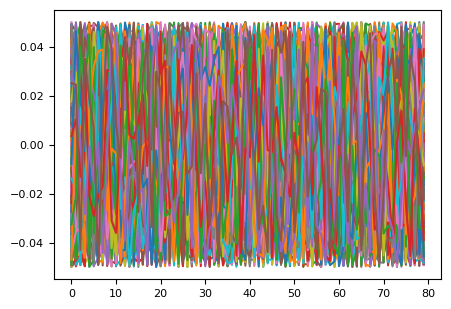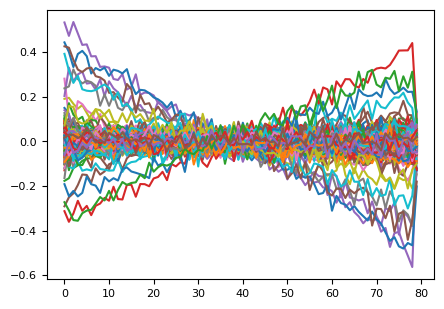

**Token Embedding Layer's Weights**

In [25]:
# plt.plot(model.layers[1].weights[0].numpy()[:80,:])
# plt.show()

**Epoch=0** --> **Epoch=20**      

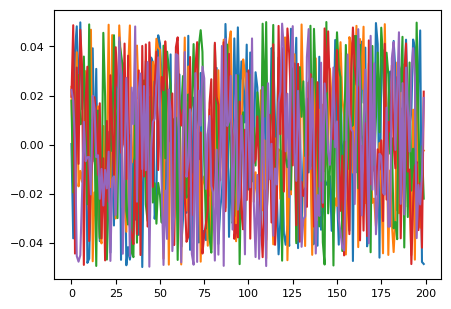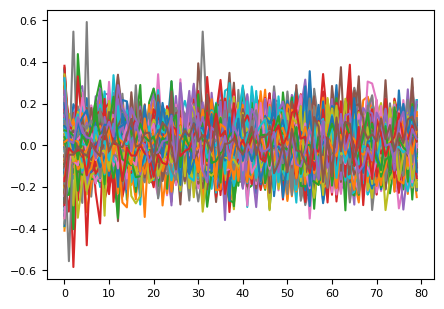

In [26]:
%%time
#model = create_model()
epochs = 5 #25
verbose = 1
history = model.fit(text_ds, verbose=verbose, epochs=epochs, callbacks=[text_gen_callback])
# Wall time: 3min 23s

Epoch 1/5
    391/Unknown 75s 120ms/step - loss: 6.1682

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



'this movie is an [UNK] , [UNK] [UNK] of two movies , with the first [UNK] [UNK] ) , but i have a few years ago and i watched it in the last night on a video , which i had seen my life'

391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - loss: 6.1668
Epoch 2/5
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.9166
'this movie is a terrible film , i 'm a huge fan of the movie . it was a good film i can tell the plot and acting was pretty good , but i am glad i got to see this film and [UNK]'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - loss: 4.9161
Epoch 3/5
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.6238
'this movie is a very good movie . i have not watched in any way , but i found myself wanting to be a huge disappointment . i was disappointed , i couldn 't wait to see this . i 'm a huge fan'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 4.6236
Epoch 4/5
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.4589
'this movie is a very good film for me , and i found it a lit

In [27]:
%%time
#model = create_model()
epochs = 25
verbose = 1
history = model.fit(text_ds, verbose=verbose, epochs=epochs, callbacks=[text_gen_callback])

Epoch 1/25
    390/Unknown 27s 70ms/step - loss: 4.2356
'this movie is so bad . the acting is awful and not even the worst movie i can only imagine how to make an episode of [UNK] . the show is the last episode , but it 's not only one thing about the'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 4.2355
Epoch 2/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.1464
'this movie is a great movie ! if you like the movie , then you 'll love this movie , it 's a movie i 've seen the first two of my friends and i have to say that this is a great example'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - loss: 4.1464
Epoch 3/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.0654
'this movie is so bad that it was made in the same old way that i 've spent many hours watching this movie and was so bad that i could get a kick out of this . i was not the first film ,'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 4.0653
Epoch 4/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



'this movie is great . there 's no way to describe how bad this film is , not a movie that is , but there are no one or a lot of the elements of a story , the acting is bad . the'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - loss: 3.9248
Epoch 6/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.8635
'this movie is terrible . i can 't believe it and i don 't think this is what a terrible movie i have no idea . i 'm really surprised that the characters were not developed . this movie was just pathetic . i'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - loss: 3.8635
Epoch 7/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.8057
'this movie is a movie of any kind of a genre , but a film about a bunch of punks who decide to throw in a dash of wine , and his buddies [UNK] - - [UNK] and their mechanical . he meets a'

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 3.8057
Epoch 8/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7541
'this movie is not a good movie . i love

L4 : Wall time: 7min 47s  
V100 : Wall time: 7min 25s



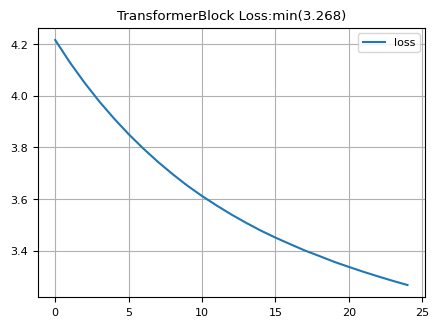

In [28]:
h1 = history.history

plt.title(f"TransformerBlock Loss:min({min(h1['loss']):.3f})")
plt.plot(h1['loss'], label='loss')
#plt.semilogy()
plt.legend()
plt.grid()
plt.show()

**Head: 2-->4**

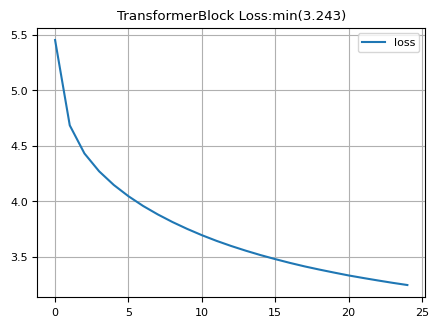

**Modified Transformer Block**  

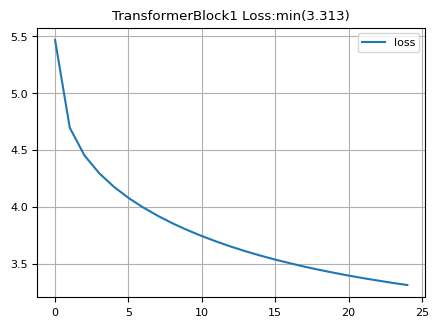

**Original Transformer Block**

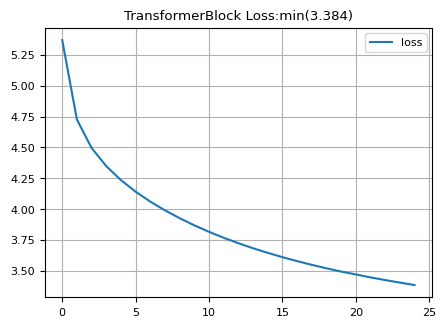

## Text Generation


In [29]:
for i in range(10):
  text_gen_callback.on_epoch_end(0)


'this movie is about [UNK] [UNK] , a woman who has been diagnosed with the fbi , ' in a small role that has a [UNK] and [UNK] , a man named carol (well she is the best of the movie that does not'


'this movie is a great movie . . .it has some great acting , good story lines . if you are the actors [UNK] [UNK] and an amazing plot line and acting . the story is simple in that movie . but it 's'


'this movie is a really bad movie , even in a movie ! it 's like a good movie . it 's not a terrible story . it 's like that . the plot is about the acting and script is very poor and'


'this movie is just a movie that is so bad it 's just bad . i don 't know how much i mean . the only reason i was because i think it was so bad to see how i was this film is'


'this movie is terrible . the acting is terrible . the acting is laughable and the plot of this film . it is not a typical hollywood comedy , but a [UNK] [UNK] story in a long pace of the film making for all'


'this movie is about a yo

**Modified Transformer Block**  

```
'this movie is the best movie i have seen in that , but it is the best of all time . the acting is not a very good , it makes you want to see the story for all ages . it is a'
'this movie is one of the worst movie i have ever seen ! there are absolutely no plot in the movie . this is just a waste of time i don 't think the writer and director was a director 's script with a'
'this movie is not the worst movie i have ever seen . i 'm not sure whether it would get better . i 'm not really really sure if you want to see it . the acting is bad , the story , it'
'this movie is a waste of time . this is a very boring movie . if it is an action thriller with an escalating nature . monstrous monsters , then irritatingly clichéd , empty . throw in a budget independent film that delivers a'
'this movie is really a great movie that i have seen since , but it has nothing to do with it ! i am not a big fan of a horror movie . it is so bad it 's just a boring . the'
'this movie is not a very good movie i 've seen . it 's a bad movie , it 's a very good movie . the acting was a very solid script . the story is so bad and i can 't wait to'
'this movie is very very cheaply made , and very much to add to the plot of the movie to this movie . it is not really a very realistic movie and very well done , not very much . i 'm also a'
'this movie is one of the worst movies you have ever seen . i can 't say this isn 't bad in it . the movie is bad , it really stinks . the acting is bad and just bad . there are no'
'this movie is a good movie to get my money on . it 's not even if not a movie . it does not get the good job , but the acting is awful , not for sure , but it 's not funny'
'this movie is the worst movie i have ever seen , but it is not so terrible that a waste of time . i have seen worse and a movie i have ever seen . i have not seen any bad movie , not'


**Original Transformer Block**

```
'this movie is a complete waste of celluloid . it is not the worst i have ever seen . . . . . . . it seems to be the worst part of a handful of notable , though i 'm not sure what'
'this movie is a very good movie . the story is about two people who are trying to do and the movie but it fails , in every sense of reality that whips the murders are just at the beginning of the end .'
'this movie is not even a movie . i don 't know if you 've got to see it . it isn 't as bad as it is , it 's not funny , i 'm not going to be an honest choice .'
'this movie is not only a movie . not only is the best film of [UNK] in the genre of the original . but that 's not so bad that the only thing that is that it is a bad movie . the only'
'this movie is not funny . you should have been a movie . the only reason for this movie was to be so bad i could think of it . it was not a real movie . there was a lot of people like'
'this movie is one of my favorite movies of all time . this is not for all tastes . i thought i was wrong . i 'm not sure what i 've seen this one . i 've seen a few [UNK] of the'
'this movie is a great movie , but it 's not very good but it is a waste of celluloid . . . . . . it is so bad that i think it was a great movie . . . . but the'
'this movie is a very good , original movie , and it was just a waste of time . a bunch of amateurs , the script is not just a good movie . it is a story of two different from the same period'
'this movie is the worst i have ever seen . i am not sure whether i was watching the movie and it is a waste of time . i was a kid from my parents , and i still think it was a huge'
'this movie is a complete waste of celluloid . the director of his films is so far and worse . the plot is rehashed action , action , action packed and boring . it is just plain bad . bad acting , bad script'
```


# 실습과제 : 모델을 키워보자   
## Transfomer block을 3개로 늘려보자   
## Head를 4-->8로 늘리면 성능이 좋아질까?
## 3epoch 학습하면 변화가 보이는지 확인해 보자